# Comparison between pychromVAR and chromVAR: Part II

## Run pychromVAR on the example data

Import packages

In [1]:
import anndata
from pyjaspar import jaspardb
import pychromvar as pc
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import seaborn as sns

In [2]:
pc.__version__

'0.0.2'

We can load the data as an anndata object

In [3]:
adata = anndata.read_csv("./counts.csv").transpose()
adata

AnnData object with n_obs × n_vars = 50 × 29269

Before we jump into the running, we need a reference genome for GC bias and motif matching. Here pychromVAR provide a function **get_genome** to
allow you to download genome sequence that we need. If you already have one, then this step can be skipped.

In [4]:
#pc.get_genome("hg19", output_dir="./")

We first extract the sequence information for each peak:

In [5]:
pc.add_peak_seq(adata, genome_file="./hg19.fa")

100%|████████████████████████████████████████████████████████████████████████| 29269/29269 [00:02<00:00, 11989.74it/s]


Then we can estimate GC bias per peak and get the backgrounds

In [6]:
pc.add_gc_bias(adata)
pc.get_bg_peaks(adata)

100%|███████████████████████████████████████████████████████████████████████| 29269/29269 [00:00<00:00, 152236.53it/s]
/Users/zhijianli/miniconda3/envs/pychromvar/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


We next extract TF motifs and perform motif matching to identify TF binding sites

In [7]:
jdb_obj = jaspardb(release='JASPAR2020')
motifs = jdb_obj.fetch_motifs(
    collection = 'CORE',
    tax_group = ['vertebrates'])

pc.match_motif(adata, motifs=motifs, p_value=5e-05)

100%|█████████████████████████████████████████████████████████████████████████| 29269/29269 [00:12<00:00, 2330.71it/s]


With these information, we can estimate TF binding sites accessibility deviations with function **compute_deviations**. This function will return an Anndata object with cells * motifs.

In [8]:
dev = pc.compute_deviations(adata)

2023-01-27 19:27:03 INFO     computing expectation reads per cell and peak...
2023-01-27 19:27:03 INFO     computing observed motif deviations...
2023-01-27 19:27:03 INFO     computing background deviations...


## Compare with chromVAR

We next compare the results between pychromVAR and [chromVAR](https://github.com/GreenleafLab/chromVAR) by calculating the correlation of each cells across all TFs. If these two results are similar, we should observe a high correlation.

In [9]:
df_pychromvar = pd.DataFrame(dev.X, 
                            columns=dev.var_names, 
                            index=dev.obs_names)

df_chromvar = pd.read_csv("./chromvar_z.csv", index_col=0)

correlation = df_pychromvar.corrwith(df_chromvar, axis = 1)

<AxesSubplot: >

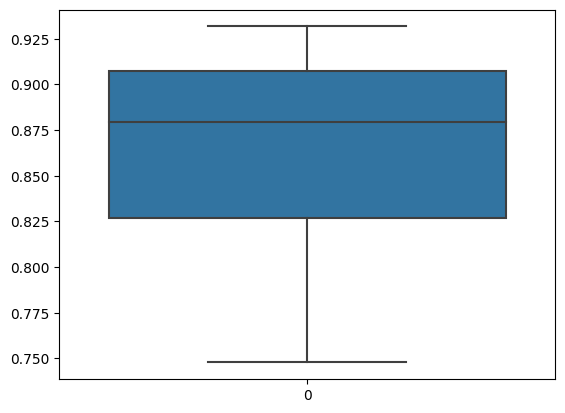

In [10]:
sns.boxplot(data=correlation)

In [11]:
# # add background peaks
#df_bg_peaks = pd.read_csv("./bg_peaks.csv", index_col=0)
#adata.varm['bg_peaks'] = df_bg_peaks.to_numpy() - 1

#df_motif_match = pd.read_csv("./chromvar_motif_match.csv", index_col=0)
#adata.varm['motif_match'] = df_motif_match.to_numpy()